### List of Imports

In [2]:
from __future__ import print_function

In [3]:
import json
import pickle
import numpy as np 
import pandas as pd 
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
# from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline

/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
pd.options.display.max_rows = 15

In [5]:
with open('../../../../raw_data/train.json', 'rb') as f:
    dict_ = json.load(f)

In [6]:
df = pd.DataFrame.from_dict(dict_)

In [7]:
df.ingredients = [','.join(i).strip() for i in df.ingredients]  

In [8]:
df.head(5)

,cuisine,id,ingredients
0,greek,10259,"romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"plain flour,ground pepper,salt,tomatoes,ground..."
2,filipino,20130,"eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,indian,22213,"water,vegetable oil,wheat,salt"
4,indian,13162,"black pepper,shallots,cornflour,cayenne pepper..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [10]:
df['cuisine'].value_counts().sort_values(ascending=False)

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
                ... 
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, Length: 20, dtype: int64

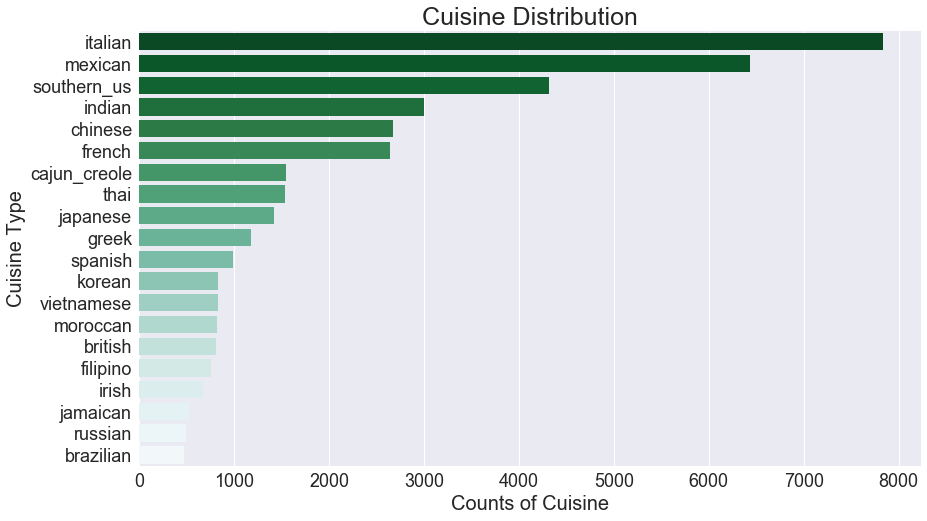

In [11]:
sns.set(rc={"figure.figsize": (14,8)}, font_scale=1.8)
ax = sns.countplot(y=df['cuisine']
                   , data=df
                   , order=['italian','mexican','southern_us'
                            ,'indian','chinese','french'
                            ,'cajun_creole','thai','japanese'
                            ,'greek','spanish','korean','vietnamese'
                            ,'moroccan','british','filipino','irish'
                            ,'jamaican','russian', 'brazilian']
                   , palette = "BuGn_r")
plt.title('Cuisine Distribution',fontsize=25)
plt.xlabel('Counts of Cuisine',fontsize=20)
plt.ylabel('Cuisine Type', fontsize=20)

# plt.savefig('../../Visuals/cuisinecnt.png', dpi=200, bbox_inches = 'tight')

### Build volcabulary for ingredients 

#### There are nearly 90k ingredients (with duplicates) out of 39774 cuisines in the dataset, so when building the vocabulary for ingredients, I wanted to set a reasonable threshold to get rid of terms that have a low document frequency. Given the size of the data and ingredients count, I decided to set the initial threshold at 100, meaning only ingredient terms appear more than 100 times across the dataset will be kept. 

In [12]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"plain flour,ground pepper,salt,tomatoes,ground..."
2,filipino,20130,"eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,indian,22213,"water,vegetable oil,wheat,salt"
4,indian,13162,"black pepper,shallots,cornflour,cayenne pepper..."


In [13]:
ingredients = df.ingredients
vec = CountVectorizer(min_df=100, tokenizer=lambda x: x.split(','), analyzer = 'word')
count = vec.fit_transform(ingredients).toarray()
igt_names = vec.get_feature_names()

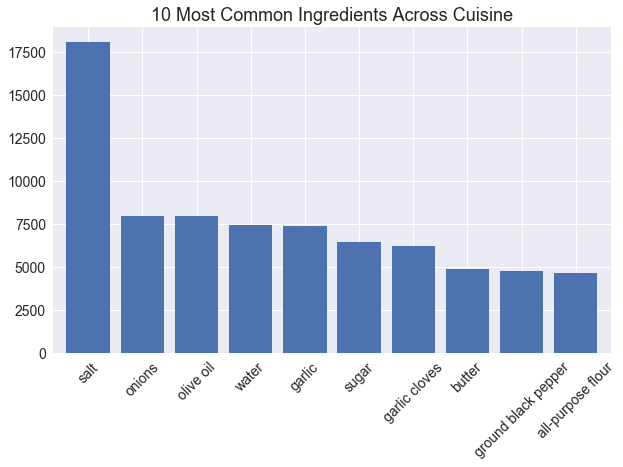

In [14]:
# ingredient frequency before further cleaning 
igt_frequency = pd.Series(count.sum(axis=0),index = igt_names).sort_values(ascending=False)
ax = igt_frequency[:10].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=45,
            title='10 Most Common Ingredients Across Cuisine')
ax.title.set_size(18)

In [15]:
# for i,count in zip(igt_names,np.asarray(count.sum(axis=0)).ravel())[0:10]:
#     print(i,count)

In [16]:
counts = np.clip(count, 0, 1, out=count)
counts_reshaped = counts.reshape(len(ingredients),len(igt_names))
df_igt = pd.DataFrame(counts_reshaped)
df_igt.columns = igt_names

In [17]:
df_igt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 650 entries,  drain to zucchini
dtypes: int64(650)
memory usage: 197.2 MB


In [18]:
df_igt.columns

Index([' drain', ' soften', '1% low-fat milk', 'active dry yeast',
       'all purpose unbleached flour', 'all-purpose flour', 'allspice',
       'almond extract', 'almonds', 'ancho chile pepper',
       ...
       'wonton wrappers', 'worcestershire sauce', 'yeast',
       'yellow bell pepper', 'yellow corn meal', 'yellow onion',
       'yellow squash', 'yoghurt', 'yukon gold potatoes', 'zucchini'],
      dtype='object', length=650)

In [19]:
# Gets rid of unwanted white spaces in column names 
df_igt = df_igt.rename(columns=lambda x: x.strip())

In [20]:
# Re-orders columns by alphabetical order of column names 
df_igt = df_igt.reindex_axis(sorted(df_igt.columns), axis=1)

In [21]:
df_igt.columns

Index(['1% low-fat milk', 'active dry yeast', 'all purpose unbleached flour',
       'all-purpose flour', 'allspice', 'almond extract', 'almonds',
       'ancho chile pepper', 'anchovy fillets', 'andouille sausage',
       ...
       'wonton wrappers', 'worcestershire sauce', 'yeast',
       'yellow bell pepper', 'yellow corn meal', 'yellow onion',
       'yellow squash', 'yoghurt', 'yukon gold potatoes', 'zucchini'],
      dtype='object', length=650)

In [253]:
df_igt

,1% low-fat milk,active dry yeast,all purpose unbleached flour,all-purpose flour,allspice,almond extract,almonds,ancho chile pepper,anchovy fillets,andouille sausage,...,wonton wrappers,worcestershire sauce,yeast,yellow bell pepper,yellow corn meal,yellow onion,yellow squash,yoghurt,yukon gold potatoes,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Merge the ingredient vocabulary with cuisine dataframe 

##### Checks one cuisine to make sure each row in df_igt is the corresponding ingredients for each row in df_train

In [255]:
df.iloc[2,2]

'eggs,pepper,salt,mayonaise,cooking oil,green chilies,grilled chicken breasts,garlic powder,yellow onion,soy sauce,butter,chicken livers'

In [256]:
# All matches except for 'grilled chicken breasts' and 'chicken livers' which is not in the ingredients vocab 
# due to its lower-than-100 frequency in all cuisines
df_igt.loc[2,'eggs'] == 1
# df_igt.loc[2,'pepper'] == 1
# df_igt.loc[2,'mayonaise'] == 1
# df_igt.loc[2,'cooking oil'] == 1
# df_igt.loc[2,'green chilies'] == 1
# df_igt.loc[2,'butter'] == 1

True

In [24]:
df.reset_index(drop=True, inplace=True)
df_igt.reset_index(drop=True, inplace=True)
df_cuisine = pd.concat([df, df_igt], axis=1)

In [25]:
df_cuisine.columns

Index(['cuisine', 'id', 'ingredients', '1% low-fat milk', 'active dry yeast',
       'all purpose unbleached flour', 'all-purpose flour', 'allspice',
       'almond extract', 'almonds',
       ...
       'wonton wrappers', 'worcestershire sauce', 'yeast',
       'yellow bell pepper', 'yellow corn meal', 'yellow onion',
       'yellow squash', 'yoghurt', 'yukon gold potatoes', 'zucchini'],
      dtype='object', length=653)

### Cleaning & Further Categorizing Ingredients (test on a small subset) 

In [26]:
df_small = df_cuisine.iloc[780:800,3:30]

In [27]:
df_small

,1% low-fat milk,active dry yeast,all purpose unbleached flour,all-purpose flour,allspice,almond extract,almonds,ancho chile pepper,anchovy fillets,andouille sausage,...,avocado,baby spinach,baby spinach leaves,bacon,bacon slices,baguette,baking potatoes,baking powder,baking soda,balsamic vinegar
780,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
783,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# checks consecutive columns that should be merged into one column 
# - one ingredient with two names
choices = df_small.columns 
for i in range(0,len(choices)-2):
    score = fuzz.token_set_ratio(df_small.columns[i],df_small.columns[(i+1)])
    if score == 100:
        print(df_small.columns[i],df_small.columns[(i+1)])

all purpose unbleached flour all-purpose flour
baby spinach baby spinach leaves
bacon bacon slices


In [29]:
fuzz.token_set_ratio("all purpose unbleached flour",'all-purpose flour')

100

In [30]:
fuzz.token_set_ratio("bacon",'bacon slices')

100

In [31]:
# Merges consecutive columns representing the same ingredients into one column
try: 
    for i in range(0,len(choices)-2):
        score = fuzz.token_set_ratio(df_small.columns[i],df_small.columns[(i+1)])
        if score == 100:
            df_small[df_small.columns[i]] = df_small[[df_small.columns[i], df_small.columns[i+1]]].sum(axis=1)
            column2 = df_small.columns[i+1]
            df_small.drop([column2],axis = 1,inplace=True)
except IndexError:
    pass 

In [32]:
# Check to make sure duplicated columns are dropped while values for columns kept are updated
df_small.columns

Index(['1% low-fat milk', 'active dry yeast', 'all purpose unbleached flour',
       'allspice', 'almond extract', 'almonds', 'ancho chile pepper',
       'anchovy fillets', 'andouille sausage', 'apple cider vinegar', 'apples',
       'arborio rice', 'artichoke hearts', 'arugula', 'asian fish sauce',
       'asparagus', 'avocado', 'baby spinach', 'bacon', 'baguette',
       'baking potatoes', 'baking powder', 'baking soda', 'balsamic vinegar'],
      dtype='object')

In [33]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 780 to 799
Data columns (total 24 columns):
1% low-fat milk                 20 non-null int64
active dry yeast                20 non-null int64
all purpose unbleached flour    20 non-null int64
allspice                        20 non-null int64
almond extract                  20 non-null int64
almonds                         20 non-null int64
ancho chile pepper              20 non-null int64
anchovy fillets                 20 non-null int64
andouille sausage               20 non-null int64
apple cider vinegar             20 non-null int64
apples                          20 non-null int64
arborio rice                    20 non-null int64
artichoke hearts                20 non-null int64
arugula                         20 non-null int64
asian fish sauce                20 non-null int64
asparagus                       20 non-null int64
avocado                         20 non-null int64
baby spinach                    20 non-null 

In [34]:
# Before the merging, 'all purpose unbleached flour' has all 0s, now its first row  is 1,
# which confirms the success of the merging 
df_small['all purpose unbleached flour']

780    1
781    0
782    0
783    0
784    0
785    0
786    0
      ..
793    0
794    0
795    0
796    0
797    0
798    0
799    0
Name: all purpose unbleached flour, Length: 20, dtype: int64

### Cleaning & Further Categorizing Ingredients (on the whole dataset) 

In [35]:
df_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 653 entries, cuisine to zucchini
dtypes: int64(651), object(2)
memory usage: 198.2+ MB


In [36]:
df_cuisine.columns

Index(['cuisine', 'id', 'ingredients', '1% low-fat milk', 'active dry yeast',
       'all purpose unbleached flour', 'all-purpose flour', 'allspice',
       'almond extract', 'almonds',
       ...
       'wonton wrappers', 'worcestershire sauce', 'yeast',
       'yellow bell pepper', 'yellow corn meal', 'yellow onion',
       'yellow squash', 'yoghurt', 'yukon gold potatoes', 'zucchini'],
      dtype='object', length=653)

In [37]:
# ingredients = df_cuisine.columns
# for i in ingredients: 
#     ing = process.extract(i, ingredients, limit=2, scorer = fuzz.token_set_ratio)
#     if ing[0][1] == ing[1][1]:
#         print(ing)

* The below process needs to be run several times until no consecutive columns returns the same ingredients. 

In [38]:
try: 
    for i in range(0,len(ingredients)-2):
        score = fuzz.token_set_ratio(df_cuisine.columns[i],df_cuisine.columns[(i+1)])
        if score == 100:
            df_cuisine[df_cuisine.columns[i]] = df_cuisine[[df_cuisine.columns[i], df_cuisine.columns[i+1]]].sum(axis=1)
            column2 = df_cuisine.columns[i+1]
            df_cuisine.drop([column2],axis = 1,inplace=True)
except IndexError:
    pass

In [39]:
df_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 589 entries, cuisine to zucchini
dtypes: int64(587), object(2)
memory usage: 178.7+ MB


##### Pickle the cleaned dataframe & a small subset as a sample 

In [40]:
df_cleaned_sample = df_cuisine[0:50]

In [41]:
df_cleaned_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 589 entries, cuisine to zucchini
dtypes: int64(587), object(2)
memory usage: 230.2+ KB


In [42]:
# Before further cleaning 
with open('../../Data/cuisine_clean.pickle', 'wb') as handle: 
    pickle.dump(df_cuisine, handle, pickle.HIGHEST_PROTOCOL)

In [43]:
with open('../../Data/cuisine_clean_sample.pickle', 'wb') as handle: 
    pickle.dump(df_cleaned_sample, handle, pickle.HIGHEST_PROTOCOL)

### More feature engineering (for 2nd round of training & modeling)
##### Additional merges on the same ingredients (on the most common ones) but not in consecutive columns 

In [44]:
df_cuisine.columns[df_cuisine.columns.str.contains('flour')]

Index(['all purpose unbleached flour', 'bread flour', 'cake flour',
       'cornflour', 'flour', 'plain flour', 'self rising flour',
       'whole wheat flour'],
      dtype='object')

In [45]:
df_cuisine['flour'] = df_cuisine[['all purpose unbleached flour'
                        ,'whole wheat flour','flour'
                        ,'plain flour','self rising flour']].sum(axis=1)
df_cuisine.drop(['all purpose unbleached flour','whole wheat flour'
            ,'plain flour','self rising flour'],axis=1,inplace=True)

In [46]:
df_cuisine.columns[df_cuisine.columns.str.contains('pepper')]

Index(['ancho chile pepper', 'bell pepper', 'black pepper',
       'black peppercorns', 'chile pepper', 'chili pepper',
       'chopped green bell pepper', 'cracked black pepper',
       'crushed red pepper', 'dried red chile peppers',
       'freshly ground pepper', 'green bell pepper', 'green pepper',
       'ground black pepper', 'ground cayenne pepper', 'ground pepper',
       'ground red pepper', 'ground white pepper', 'hot pepper sauce',
       'hot red pepper flakes', 'pepper', 'peppercorns', 'poblano peppers',
       'red bell pepper', 'red chili peppers', 'red pepper',
       'roasted red peppers', 'serrano peppers', 'szechwan peppercorns',
       'tabasco pepper sauce', 'white pepper', 'yellow bell pepper'],
      dtype='object')

In [47]:
df_cuisine['pepper'] = df_cuisine[['black pepper','pepper','green pepper','freshly ground pepper'
                        ,'black peppercorns','cracked black pepper','ground pepper'
                        ,'ground black pepper','red pepper','white pepper','red pepper'
                         ,'roasted red peppers','red bell pepper','peppercorns'
                         ,'ground white pepper','bell pepper','chopped green bell pepper'
                         ,'green bell pepper','ground red pepper']].sum(axis=1)
df_cuisine.drop(['black pepper','green pepper','freshly ground pepper','red pepper'
                        ,'black peppercorns','cracked black pepper','ground pepper'
                        ,'ground black pepper','red pepper','white pepper'
                         ,'roasted red peppers','red bell pepper','peppercorns'
                         ,'ground white pepper','bell pepper','chopped green bell pepper'
                         ,'green bell pepper','ground red pepper'],axis=1,inplace=True)

In [48]:
df_cuisine.columns[df_cuisine.columns.str.contains('corn')]

Index(['corn', 'corn oil', 'corn starch', 'corn tortillas', 'cornflour',
       'cornmeal', 'frozen corn', 'light corn syrup', 'szechwan peppercorns',
       'whole kernel corn', 'yellow corn meal'],
      dtype='object')

In [49]:
df_cuisine['corn'] = df_cuisine[['corn','frozen corn','whole kernel corn']].sum(axis=1)
df_cuisine.drop(['frozen corn','whole kernel corn'],axis=1,inplace=True)

In [50]:
df_cuisine.columns[df_cuisine.columns.str.contains('onion')]

Index(['chopped onion', 'diced onions', 'finely chopped onion', 'green onions',
       'minced onion', 'onion powder', 'onions', 'purple onion',
       'sliced green onions', 'spring onions', 'sweet onion', 'vidalia onion',
       'white onion', 'yellow onion'],
      dtype='object')

In [51]:
df_cuisine['onions'] = df_cuisine[['chopped onion','diced onions','finely chopped onion'
                        ,'green onions','minced onion','onion powder','onions'
                        ,'purple onion','sliced green onions','spring onions'
                         ,'sweet onion','white onion','yellow onion']].sum(axis=1)
df_cuisine.drop(['chopped onion','diced onions','finely chopped onion'
            ,'green onions','minced onion','onion powder'
            ,'purple onion','sliced green onions','spring onions'
            ,'sweet onion','white onion','yellow onion'],axis=1,inplace=True)

In [52]:
df_cuisine.columns[df_cuisine.columns.str.contains('butter')]

Index(['butter', 'buttermilk', 'butternut squash', 'creamy peanut butter',
       'melted butter', 'peanut butter', 'unsalted butter'],
      dtype='object')

In [53]:
df_cuisine['butter'] = df_cuisine[['butter'
                        ,'melted butter','unsalted butter']].sum(axis=1)
df_cuisine.drop(['melted butter','unsalted butter'],axis=1,inplace=True)

In [54]:
df_cuisine['peanut butter'] = df_cuisine[['peanut butter'
                        ,'creamy peanut butter']].sum(axis=1)
df_cuisine.drop(['creamy peanut butter'],axis=1,inplace=True)

In [55]:
df_cuisine.columns[df_cuisine.columns.str.contains('salt')]

Index(['coarse salt', 'fine sea salt', 'garlic salt', 'kosher salt',
       'low salt chicken broth', 'salt', 'sea salt'],
      dtype='object')

In [56]:
df_cuisine['salt'] = df_cuisine[['salt','sea salt','fine sea salt'
                       ,'coarse salt','kosher salt']].sum(axis=1)
df_cuisine.drop(['sea salt','fine sea salt'
                       ,'coarse salt','kosher salt'],axis=1,inplace=True)

In [57]:
df_cuisine.columns[df_cuisine.columns.str.contains('eggs')]

Index(['eggs', 'large eggs'], dtype='object')

In [58]:
df_cuisine['eggs'] = df_cuisine[['eggs','large eggs']].sum(axis=1)
df_cuisine.drop(['large eggs'],axis=1,inplace=True)

In [59]:
df_cuisine.columns[df_cuisine.columns.str.contains('water')]

Index(['boiling water', 'cold water', 'hot water', 'ice water', 'warm water',
       'water chestnuts', 'watercress'],
      dtype='object')

In [60]:
df_cuisine['water'] = df_cuisine[['boiling water','cold water'
                        ,'hot water','warm water']].sum(axis=1)
df_cuisine.drop(['boiling water','cold water'
                        ,'hot water','warm water'],axis=1,inplace=True)

In [61]:
df_cuisine.columns[df_cuisine.columns.str.contains('sugar')]

Index(['brown sugar', 'caster sugar', 'confectioners sugar',
       'dark brown sugar', 'granulated sugar', 'light brown sugar',
       'palm sugar', 'powdered sugar', 'sugar', 'white sugar'],
      dtype='object')

In [62]:
df_cuisine['sugar'] = df_cuisine[['brown sugar','confectioners sugar','powdered sugar','sugar'
                        ,'dark brown sugar','granulated sugar','white sugar'
                        ,'light brown sugar']].sum(axis=1)
df_cuisine.drop(['brown sugar','confectioners sugar','powdered sugar'
                        ,'dark brown sugar','granulated sugar','white sugar'
                        ,'light brown sugar'],axis=1,inplace=True)

In [63]:
df_cuisine.columns[df_cuisine.columns.str.contains('oil')]

Index(['canola oil', 'chili oil', 'coconut oil', 'cooking oil', 'corn oil',
       'dark sesame oil', 'extra-virgin olive oil', 'hard-boiled egg', 'oil',
       'olive oil', 'peanut oil', 'sesame oil', 'toasted sesame oil',
       'vegetable oil'],
      dtype='object')

In [64]:
df_cuisine['oil'] = df_cuisine[['oil','cooking oil','canola oil','peanut oil'
                        ,'vegetable oil']].sum(axis=1)
df_cuisine.drop(['cooking oil','canola oil','peanut oil'
                        ,'vegetable oil'],axis=1,inplace=True)

In [65]:
df_cuisine['olive oil'] = df_cuisine[['olive oil','extra-virgin olive oil']].sum(axis=1)
df_cuisine['sesame oil'] = df_cuisine[['sesame oil','toasted sesame oil'
                                       ,'dark sesame oil']].sum(axis=1)
df_cuisine.drop(['extra-virgin olive oil','toasted sesame oil'
            ,'dark sesame oil'],axis=1,inplace=True)

In [66]:
df_cuisine.columns[df_cuisine.columns.str.contains('cilantro')]

Index(['chopped cilantro', 'cilantro', 'cilantro sprigs', 'fresh cilantro'], dtype='object')

In [67]:
df_cuisine['cilantro'] = df_cuisine[['cilantro','chopped cilantro','fresh cilantro']].sum(axis=1)

In [68]:
df_cuisine.columns[df_cuisine.columns.str.contains('garlic')]

Index(['chopped garlic', 'crushed garlic', 'garlic', 'garlic cloves',
       'garlic paste', 'garlic powder', 'garlic salt', 'large garlic cloves',
       'minced garlic'],
      dtype='object')

In [69]:
df_cuisine['garlic'] = df_cuisine[['garlic','large garlic cloves','crushed garlic'
                         ,'minced garlic','chopped garlic']].sum(axis=1)

In [70]:
df_cuisine.columns[df_cuisine.columns.str.contains('milk')]

Index(['1% low-fat milk', 'buttermilk', 'evaporated milk', 'fat free milk',
       'light coconut milk', 'milk', 'sweetened condensed milk',
       'unsweetened coconut milk', 'whole milk'],
      dtype='object')

In [71]:
df_cuisine['milk'] = df_cuisine[['milk','1% low-fat milk'
                         ,'evaporated milk','whole milk']].sum(axis=1)

In [72]:
df_cuisine.drop(['chopped cilantro','fresh cilantro','large garlic cloves'
                         ,'minced garlic','chopped garlic','1% low-fat milk'
                         ,'evaporated milk','whole milk','crushed garlic'],axis=1,inplace=True)

In [73]:
df_cuisine.columns[df_cuisine.columns.str.contains('almond')]

Index(['almond extract', 'almonds', 'sliced almonds', 'slivered almonds'], dtype='object')

In [74]:
df_cuisine['almonds'] = df_cuisine[['almonds','almond extract'
                         ,'sliced almonds','slivered almonds']].sum(axis=1)

In [75]:
df_cuisine.columns[df_cuisine.columns.str.contains('tomatoes')]

Index(['cherry tomatoes', 'chopped tomatoes', 'crushed tomatoes',
       'diced tomatoes', 'fresh tomatoes', 'grape tomatoes', 'green tomatoes',
       'plum tomatoes', 'roma tomatoes', 'stewed tomatoes',
       'sun-dried tomatoes', 'tomatoes', 'whole peeled tomatoes'],
      dtype='object')

In [76]:
df_cuisine['tomatoes'] = df_cuisine[['tomatoes','chopped tomatoes','crushed tomatoes','diced tomatoes'
                         ,'fresh tomatoes','stewed tomatoes'
                           ,'whole peeled tomatoes']].sum(axis=1)

In [77]:
df_cuisine.columns[df_cuisine.columns.str.contains('chicken broth')]

Index(['chicken broth', 'fat free less sodium chicken broth',
       'low salt chicken broth', 'low sodium chicken broth',
       'reduced sodium chicken broth'],
      dtype='object')

In [78]:
df_cuisine['chicken broth'] = df_cuisine[['fat free less sodium chicken broth'
                                ,'low salt chicken broth','low sodium chicken broth'
                                ,'reduced sodium chicken broth']].sum(axis=1)

In [79]:
df_cuisine.drop(['almond extract','chopped tomatoes','crushed tomatoes','diced tomatoes'
            ,'fresh tomatoes','stewed tomatoes','whole peeled tomatoes','sliced almonds'
            ,'slivered almonds','fat free less sodium chicken broth','low salt chicken broth'
            ,'low sodium chicken broth','reduced sodium chicken broth'],axis=1,inplace=True)

In [80]:
df_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 507 entries, cuisine to water
dtypes: int64(505), object(2)
memory usage: 153.9+ MB


In [81]:
df_cuisine_cleaner = df_cuisine

In [82]:
df_cuisine_cleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 507 entries, cuisine to water
dtypes: int64(505), object(2)
memory usage: 153.9+ MB


In [250]:
df_cuisine.columns[df_cuisine.columns.str.contains('pimento')]

Index(['pimentos'], dtype='object')

In [252]:
df_cuisine.columns[df_cuisine.columns.str.contains('vanilla ')]

Index(['pure vanilla extract', 'vanilla extract'], dtype='object')

In [248]:
df_cuisine_cleaner.iloc[:,350:380]

,peanuts,peas,pecan halves,pecans,pecorino romano cheese,peeled fresh ginger,penne,pepper,pesto,pimentos,...,pork,pork sausages,pork shoulder,pork tenderloin,potatoes,prosciutto,provolone cheese,pure vanilla extract,queso fresco,quinoa
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39767,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39768,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Pickle the cleaned dataframe & a small subset as a sample 

In [1107]:
# After further cleaning - 
# with open('../../Data/cuisine_clean2.pickle', 'wb') as handle: 
#     pickle.dump(df_cuisine_cleaner, handle, pickle.HIGHEST_PROTOCOL)